In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rosatX as rx
import pyccl as ccl
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
from getdist import plots, MCSamples, loadMCSamples
from getdist.mcsamples import MCSamplesFromCobaya

Code to calculate baryonic boost factor

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "halofit"}
cosmo = ccl.Cosmology(**COSMO_P18)
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(
    mass_function=nM, halo_bias=bM, mass_def=mdef,
    log10M_max=15., log10M_min=10, nM=32)
prof_dmo = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
k_arr = np.geomspace(1e-4, 100, 256)
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.3, 1, 8)
pk_dmo = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_dmo, lk_arr=lk_arr, a_arr=a_arr)

def get_pk_ratio(ks, zs, **kwargs):
    prof_bar = rx.HaloProfileNFWBaryon(mass_def=mdef, concentration=cM, **kwargs)
    pk_bar = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_bar, lk_arr=lk_arr, a_arr=a_arr)
    rat = np.array([pk_bar(ks, a)/pk_dmo(ks, a) for a in 1/(1+zs)])
    return rat

$k$ and $z$ sampling

In [3]:
ks = np.geomspace(0.01, 20, 256)
zs = np.array([0, 1])

Calculate for logTAGN chains

In [4]:
d = np.load('constraints_1d.npz')
ps = np.exp(-0.5*(d['chi2'][:, -1]-np.amin(d['chi2'][:, -1])))
# Reduce the number of points to evaluate
pgood = ps > 1E-3
ps = ps[pgood]
ratios = np.array([get_pk_ratio(ks, zs, logTAGN=lT) for lT in d['logTAGN'][pgood]])

# Calculate mean and standard deviation
pnorm = np.sum(ps)
rat_mean_lT = np.sum(ps[:, None, None] * ratios, axis=0)/pnorm
rat_std_lT = np.sqrt(np.sum(ps[:, None, None] * ratios**2, axis=0)/pnorm - rat_mean_lT**2)

Calculate for 4-param model chains

In [5]:
cha = loadMCSamples('chains_cobaya/chain_cobaya_all',
                    settings={'ignore_rows': 0.2})
print(np.average(cha['lMc'], weights=cha['weight']))
# Thin by a factor 20
thinfac = 20
ws = cha['weight'][::thinfac]
ratios = []
for lMc, gamma, eta_b in zip(cha['lMc'][::thinfac],
                             cha['gamma'][::thinfac],
                             cha['eta_b'][::thinfac]):
    ratios.append(get_pk_ratio(ks, zs, lMc=lMc, gamma=gamma, eta_b=eta_b))
ratios = np.array(ratios)

# Calculate mean and standard deviation
rat_mean_ch = np.sum(ratios*ws[:, None, None], axis=0)/np.sum(ws)
rat_std_ch = np.sqrt(np.sum((ratios - rat_mean_ch[None, :, :])**2*ws[:, None, None], axis=0)/np.sum(ws))

13.642718740265737


Calculate for Amon & Efstathiou model

In [6]:
def get_ratio_AE(ks, zs, Amod):
    pl = np.array([cosmo.linear_matter_power(ks, a) for a in 1/(1+zs)])
    pnl = np.array([cosmo.nonlin_matter_power(ks, a) for a in 1/(1+zs)])
    rat = Amod + pl/pnl*(1-Amod)
    return rat

# Gaussian posterior on A_mod (see Eq. 7 of 2206.11794)
Amods = np.linspace(0.3, 1.2, 256)
pAmods = np.exp(-0.5*((Amods-0.748)/0.072)**2)
ratios = np.array([get_ratio_AE(ks, zs, Amod) for Amod in Amods])
pnorm = np.sum(pAmods)
rat_mean_KiDS = np.sum(pAmods[:, None, None] * ratios, axis=0)/pnorm
rat_std_KiDS = np.sqrt(np.sum(pAmods[:, None, None] * ratios**2, axis=0)/pnorm - rat_mean_KiDS**2)

pAmods = np.exp(-0.5*((Amods-0.858)/0.052)**2)
ratios = np.array([get_ratio_AE(ks, zs, Amod) for Amod in Amods])
pnorm = np.sum(pAmods)
rat_mean_DES = np.sum(pAmods[:, None, None] * ratios, axis=0)/pnorm
rat_std_DES = np.sqrt(np.sum(pAmods[:, None, None] * ratios**2, axis=0)/pnorm - rat_mean_DES**2)

Read sim data

In [7]:
pkdat = {'BAHAMAS-7.6':
         ('BAHAMAS $T_{\\rm heat}7.6$',
          'pk_data/powtable_BAHAMAS_Theat7.6_nu0_WMAP9.dat',
          'pk_data/powtable_DMONLY_2fluid_nu0_WMAP9_L400N1024.dat'),
         'BAHAMAS-8.0':
         ('BAHAMAS $T_{\\rm heat}8.0$',
          'pk_data/powtable_BAHAMAS_Theat8.0_nu0_WMAP9.dat',
          'pk_data/powtable_DMONLY_2fluid_nu0_WMAP9_L400N1024.dat'),
         'Illustris-1':
         ('Illustris-1',
          'pk_data/powtable_Illustris-1.dat',
          'pk_data/powtable_Illustris-1-DM.dat'),
         'TNG300':
         ('TNG300',
          'pk_data/powtable_TNG300-1.dat',
          'pk_data/powtable_TNG300-1-DM.dat'),
         'Horizon-AGN':
         ('Horizon-AGN',
          'pk_data/powtable_Hz-AGN.dat',
          'pk_data/powtable_Hz-DM.dat'),
         'COSMO-OWLS':
         ('C-OWLS $T_{\\rm heat}8.7$',
          'pk_data/powtable_C-OWLS_AGN_Mseed800_Theat8.7_WMAP7_L100N512.dat',
          'pk_data/powtable_DMONLY_WMAP7_L100N512.dat')}

def parse_pkdat(dat, z=0):
    zz, kb, pkb, _ = np.loadtxt(dat[1], unpack=True)
    good = zz == z
    kb = kb[good]
    pkb = pkb[good]
    zz, kd, pkd, _ = np.loadtxt(dat[2], unpack=True)
    good = zz == z
    kd = kd[good]
    pkd = pkd[good]
    return dat[0], kd, pkb/pkd

Plot everything!

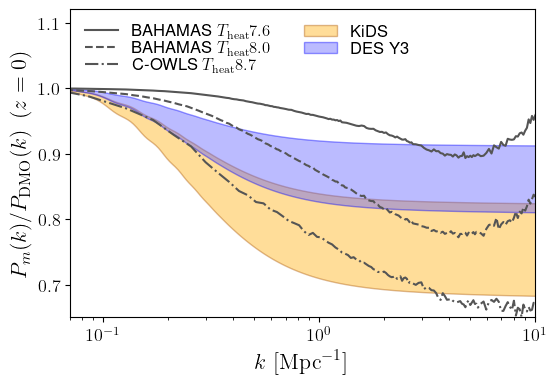

In [8]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
for sim, ls in zip(['BAHAMAS-7.6', 'BAHAMAS-8.0', 'COSMO-OWLS'], ['-', '--', '-.']):
    nm, k, r = parse_pkdat(pkdat[sim])
    plt.plot(k*cosmo['h'], r, ls, c='#555555', label=nm)
ax.fill_between(ks, rat_mean_KiDS[0]-rat_std_KiDS[0], rat_mean_KiDS[0]+rat_std_KiDS[0],
                facecolor='#FFAA00', edgecolor='#AA5500', label='KiDS', alpha=0.4)
ax.fill_between(ks, rat_mean_DES[0]-rat_std_DES[0], rat_mean_DES[0]+rat_std_DES[0],
                facecolor='#5555FF', edgecolor='b', label='DES Y3', alpha=0.4)
ax.set_xscale('log')
ax.set_xlim([0.07, 10.])
ax.set_ylim([0.65, 1.12])
ax.legend(frameon=False, fontsize=12, ncol=2, labelspacing=0.1, loc='upper left')
ax.set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P_m(k)/P_{\rm DMO}(k)\,\,\,(z=0)$', fontsize=16)
ax.tick_params(axis='both', labelsize=13)
plt.savefig('baryon_boost_norosat.pdf', bbox_inches='tight')

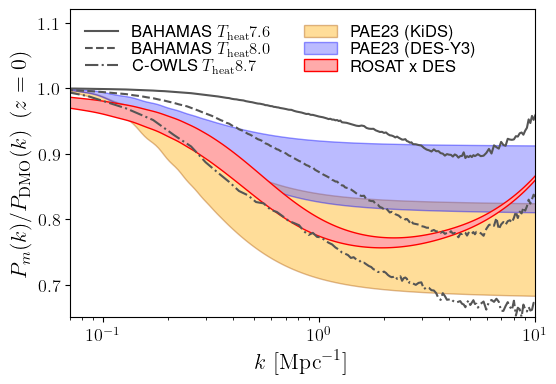

In [9]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
for sim, ls in zip(['BAHAMAS-7.6', 'BAHAMAS-8.0', 'COSMO-OWLS'], ['-', '--', '-.']):
    nm, k, r = parse_pkdat(pkdat[sim])
    plt.plot(k*cosmo['h'], r, ls, c='#555555', label=nm)
ax.fill_between(ks, rat_mean_KiDS[0]-rat_std_KiDS[0], rat_mean_KiDS[0]+rat_std_KiDS[0],
                facecolor='#FFAA00', edgecolor='#AA5500', label='PAE23 (KiDS)', alpha=0.4)
ax.fill_between(ks, rat_mean_DES[0]-rat_std_DES[0], rat_mean_DES[0]+rat_std_DES[0],
                facecolor='#5555FF', edgecolor='b', label='PAE23 (DES-Y3)', alpha=0.4)
ax.fill_between(ks, rat_mean_ch[0]-rat_std_ch[0], rat_mean_ch[0]+rat_std_ch[0],
                facecolor='#FFAAAA', edgecolor='r', label='ROSAT x DES')
#ax.fill_between(ks, rat_mean_chb[0]-rat_std_chb[0], rat_mean_chb[0]+rat_std_chb[0],
#                facecolor='#AAFFAA', edgecolor='g')#, label='ROSAT x DES')
ax.set_xscale('log')
ax.set_xlim([0.07, 10.])
ax.set_ylim([0.65, 1.12])
ax.legend(frameon=False, fontsize=12, ncol=2, labelspacing=0.1, loc='upper left')
ax.set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P_m(k)/P_{\rm DMO}(k)\,\,\,(z=0)$', fontsize=16)
ax.tick_params(axis='both', labelsize=13)
plt.savefig('baryon_boost.pdf', bbox_inches='tight')

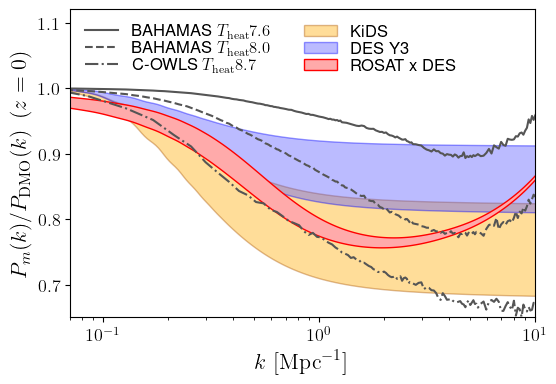

In [10]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
for sim, ls in zip(['BAHAMAS-7.6', 'BAHAMAS-8.0', 'COSMO-OWLS'], ['-', '--', '-.']):
    nm, k, r = parse_pkdat(pkdat[sim])
    plt.plot(k*cosmo['h'], r, ls, c='#555555', label=nm)
ax.fill_between(ks, rat_mean_KiDS[0]-rat_std_KiDS[0], rat_mean_KiDS[0]+rat_std_KiDS[0],
                facecolor='#FFAA00', edgecolor='#AA5500', label='KiDS', alpha=0.4)
ax.fill_between(ks, rat_mean_DES[0]-rat_std_DES[0], rat_mean_DES[0]+rat_std_DES[0],
                facecolor='#5555FF', edgecolor='b', label='DES Y3', alpha=0.4)
ax.fill_between(ks, rat_mean_ch[0]-rat_std_ch[0], rat_mean_ch[0]+rat_std_ch[0],
                facecolor='#FFAAAA', edgecolor='r', label='ROSAT x DES')
#ax.fill_between(ks, rat_mean_chb[0]-rat_std_chb[0], rat_mean_chb[0]+rat_std_chb[0],
#                facecolor='#AAFFAA', edgecolor='g')#, label='ROSAT x DES')
ax.set_xscale('log')
ax.set_xlim([0.07, 10.])
ax.set_ylim([0.65, 1.12])
ax.legend(frameon=False, fontsize=12, ncol=2, labelspacing=0.1, loc='upper left')
ax.set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P_m(k)/P_{\rm DMO}(k)\,\,\,(z=0)$', fontsize=16)
ax.tick_params(axis='both', labelsize=13)
plt.savefig('baryon_boost_erc.pdf', bbox_inches='tight')